In [46]:
#FINAL
import kagglehub
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.neural_network import MLPRegressor
import numpy as np
import math
from sklearn.neighbors import KernelDensity

#Fuente
data = kagglehub.dataset_download("jahnavipaliwal/customer-feedback-and-satisfaction")
file_path = os.path.join(data, "customer_feedback_satisfaction.csv")

#Convertir a DataFrame
df = pd.read_csv(file_path)
print(df.describe())

#Generar datos artificiales

#Definir el corte en el 1%
Corte = df['SatisfactionScore'].quantile(0.01)
dfq1= df[df['SatisfactionScore'] <= Corte]

np.random.seed(42)  #Definir semilla en random

nuevodf = pd.DataFrame()
for col in dfq1.columns:
  if dfq1[col].dtype in [np.float64, np.int64]:  # Numericos
    kde = KernelDensity(kernel='gaussian', bandwidth=0.5).fit(dfq1[[col]])
    synthetic_samples = kde.sample(28000, random_state=42)
    nuevodf[col] = synthetic_samples.flatten()
  else:
    nuevodf[col] = np.random.choice(dfq1[col], 28000) #No numericos

df = pd.concat([df, nuevodf], ignore_index=True)
print(df.describe())

#Eliminar ID y definir Y
df.drop(columns=['CustomerID'])
Y = df['SatisfactionScore']
df.drop(columns=['SatisfactionScore'])


#Escalar los datos tanto numericos como categoricos
escalado = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['Age','Income','ProductQuality','ServiceQuality','PurchaseFrequency']),
        ('cat', OneHotEncoder(), ['Gender', 'Country','FeedbackScore','LoyaltyLevel'])
    ])

#Definir X
X = escalado.fit_transform(df)

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

#Aplicar PCA para reducir la complejidad
pca = PCA(n_components=0.95)  # Retener el 95% de la varianza
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Se definen los 3 modelos diferentes a utilizar
rf = RandomForestRegressor(n_estimators=200, random_state=42)
gb = GradientBoostingRegressor(n_estimators=200, random_state=42)
mlp = MLPRegressor(hidden_layer_sizes=(100, 50, 50), max_iter=500, random_state=42)

# Se utiliza VotingRegressor para ensamblar los 3 modelos
ensemble = VotingRegressor(estimators=[('rf', rf), ('gb', gb), ('mlp', mlp)])

#Ajuste del modelo
ensemble.fit(X_train_pca, y_train)

# Evaluar el modelo
y_pred_ensemble = ensemble.predict(X_test_pca)

#Metricas
error_ensemble = mean_squared_error(y_test, y_pred_ensemble)
print(f'Error Cuadrático Medio con Ensamblado: {error_ensemble}')
print(f"R^2: {ensemble.score(X_test_pca,y_test)}")


print(f'Root Mean Squared Error (RMSE): {math.sqrt(error_ensemble)}')

# Calcular MAE
mae = mean_absolute_error(y_test, y_pred_ensemble)
print(f'Mean Absolute Error (MAE): {mae}')

         CustomerID           Age         Income  ProductQuality  \
count  38444.000000  38444.000000   38444.000000    38444.000000   
mean   19222.500000     43.496853   75076.619238        5.494746   
std    11097.971211     14.972748   25975.752966        2.873192   
min        1.000000     18.000000   30001.000000        1.000000   
25%     9611.750000     31.000000   52624.500000        3.000000   
50%    19222.500000     43.000000   75236.000000        5.000000   
75%    28833.250000     56.000000   97606.750000        8.000000   
max    38444.000000     69.000000  119999.000000       10.000000   

       ServiceQuality  PurchaseFrequency  SatisfactionScore  
count    38444.000000       38444.000000       38444.000000  
mean         5.492769          10.453881          85.276409  
std          2.875812           5.765621          16.898577  
min          1.000000           1.000000           4.280000  
25%          3.000000           5.000000          74.470000  
50%          5.

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Error Cuadrático Medio con Ensamblado: 53.53638402336876
R^2: 0.9397380069750937
Root Mean Squared Error (RMSE): 7.316856157077899
Mean Absolute Error (MAE): 4.858757936148995


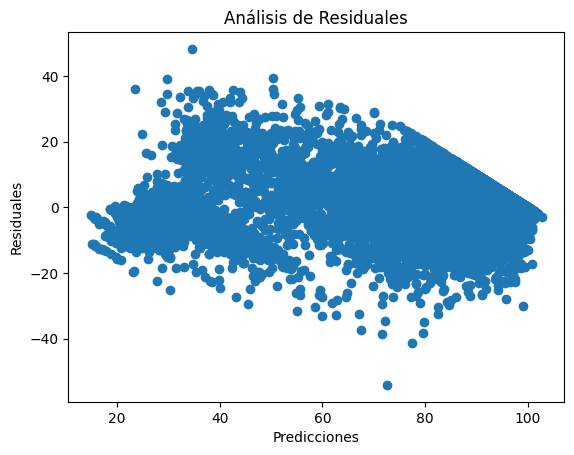

   CustomerID   Age  Gender Country   Income  ProductQuality  ServiceQuality  \
0         1.0  56.0    Male      UK  83094.0             5.0             8.0   
1         2.0  69.0    Male      UK  86860.0            10.0             2.0   
2         3.0  46.0  Female     USA  60173.0             8.0            10.0   
3         4.0  32.0  Female      UK  73884.0             7.0            10.0   
4         5.0  60.0    Male      UK  97546.0             6.0             4.0   

   PurchaseFrequency FeedbackScore LoyaltyLevel  SatisfactionScore  
0                5.0           Low       Bronze              100.0  
1                8.0        Medium         Gold              100.0  
2               18.0        Medium       Silver              100.0  
3               16.0           Low         Gold              100.0  
4               13.0           Low       Bronze               82.0  


In [47]:
# Análisis de errores
residuals = y_test - y_pred_ensemble
import matplotlib.pyplot as plt
plt.scatter(y_pred_ensemble, residuals)
plt.xlabel('Predicciones')
plt.ylabel('Residuales')
plt.title('Análisis de Residuales')
plt.show()

print(df.head())